# Modelo dinámico para la propagación del virus COVID-19 en Colombia #

A continuación se presenta el desarrollo de un modelo dinámico basado en el modelo epidemiológico SEIRV [en Wuhan, China](http://www.aimspress.com/article/10.3934/mbe.2020148) y, adaptado a la población colombiana (50 millones de habitantes aproxiadamente). 

El sistema se describe con el siguiente conjunto de ecuaciones diferenciales

---

$$ \frac{dS}{dt} = \Lambda - \beta_1(E) E S - \beta_2(I) S I - \beta_3(V) S V - \mu S $$

---

$$ \frac{dE}{dt} =  \beta_1(E) E S + \beta_2(I) S I + \beta_3(V) S V - (\alpha + \mu) E $$

---

$$ \frac{dI}{dt} = \alpha E - (\omega + \gamma + \mu) I $$

---

$$ \frac{dR}{dt} = \gamma I - \mu R $$

---

$$ \frac{dV}{dt} = \xi_1 E + \xi_2 I - \sigma V $$

---

donde S es el número de personas sanas no infectadas, E el número de personas expuestas (portadores asintomaticos o sanos que propagan el virus), I las peronas enfermas, R las personas sanas que se recuperaron del virus y V es la concentración de virus en el ambiente


Las __Funciones de Contacto Directo__ (tasas $\beta$) toman la forma $$ \beta_i(x) = \frac{\beta_0(i)}{1 + c(i)x}  $$ siendo $\beta_1$ para el contacto E-S (transmisión directa expuestos-sanos), $\beta_2$ para el contacto (transmisión directa infectados-sanos) I-S y  $\beta_3$ para el contacto S-V (transmisión indirecta sanos-ambiente). Ademas, se tienen los siguientes valores para la constante de transmisión $\beta_0$ ($\frac{1}{persona \ dia}$) y  el coeficiente de ajuste para la transmisión $c$ ($\frac{1}{persona}$).

$$ \beta_0 = [1.65 \times 3.11 \times 10^{-9}, 1.6 \times 0.62 \times 10^{-9}, 1.6 \times 1.03 \times 10^{-9}] $$

$$ c = [1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}, \ 1.01 \times 10^{-4}  ] $$

cabe notar que los anteriores valores han sido adaptados a partir de los datos disponibles para Colombia. 

Por último, todos los __parámetros del modelo__ se describen a continuación:

$\Lambda \ (\frac{personas}{dia}) = 15.098 \times 5 \times 10^4 \times \frac{1}{365} $: Tasa de natalidad. se usa dato reportado por el banco mundial en el 2017. 

$\mu \ (\frac{persona}{dia}) = \frac{5.503 \times 5 \times 10^4}{5 \times 10^6 \times 365} $: Tasa de muertes naturales. Se usa dato reportado por el BM de 5.503 por mil habitantes.

$\alpha \ (\frac{1}{dia})=\frac{1}{7}$: Frecuencia de incubación.

$\omega \ (\frac{1}{dia})= 10^{-2} $: Tasa de muerte inducida por el virus.

$\gamma \ (\frac{1}{dia})= \frac{1}{15} $: Tasa de recuperación. 

$\xi_1 \ (\frac{1}{dia}) = 2.30$: Tasa de dispersión del virus al ambiente por los individuos sanos portadores.

$\xi_2 \ (\frac{1}{dia}) = 0$: Tasa de dispersión del virus al ambiente por los individuos enfermos.

$\sigma \ (\frac{1}{dia}) = 1$: Tasa de remoción del virus en el ambiente.

In [1]:
##=== Importando librerías ===##
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
##=== Definiendo valores de parametros==##

lbd = (15.098*5* 10**4) / 365        #tasa de natalidad 
mu = (5.503*5* 10**4) / (5* pow(10, 6) *365)      #tasa de muertes naturales 
alpha = 1/7      #frecuencia de incubación
omega = pow(10,-2)      #tasa de muerte inducida por el virus
gama = 1/15      #tasa de recuperación 
xi_1 = 2.30      #tasa de dispersión del virus al ambiente por los individuos sanos portadores
xi_2 = 0       #tasa de dispersión del virus al ambiente por los individuos enfermos
sigma = 1       #tasa de remoción del virus en el ambiente 

def betaf(i, x): 
    ''' Función generalizada de las funciones de contacto directo
    Entradas: i - número de función beta (1,2,3) ; x - variable 
    Salida: valor de beta_i para la variable x
    '''
    b0 = [1.65*3.11*pow(10, -9), 1.6*0.62*pow(10, -9), 1.6*1.03*pow(10, -9)]
    c = [1.01*pow(10, -4), 1.01*pow(10, -4), 1.01*pow(10, -4)]
    
    b = b0[i-1] / (1 + c[i-1]*x)
    
    return b

##=== Definiendo sistema de ecuaciones ===##

def syst(y, t, beta, xi_2):
    ''' sistema de ecuaciones diferenciales a usar
    Entradas: y - vector de estado (list) ; t - tiempo ; 
            beta - función de contacto directo ; xi_2 - parámetro 
    Salida: lista con la evolución en el tiempo t del vector y
    '''
    S, E, I, R, V = y
    
    dS = lbd - beta(1, E)*E*S - beta(2, I)*S*I - beta(3,V)*S*V - mu*S
    dE = beta(1,E)*E*S + beta(2,I)*S*I + beta(3,V)*S*V - (alpha + mu)*E
    dI = alpha*E - (omega + gama + mu)*I
    dR = gama*I - mu*R 
    dV = xi_1*E + xi_2*I - sigma*V
    
    return [dS, dE, dI, dR, dV]

para las __condiciones iniciales__ en la integración se tienen dos posibilidades, las dadas en el artículo para la epidemia de Wuhan después de la cuarentena ($sys0_w$) o, las condiciones iniciales para el inicio de la epidemia en una población de tamaño n ($sys0_n$)

$$ sys0_w = [8998505, 1000, 475, 10, 10000] $$
$$ sys0_n = [n, 0, 0, 0, 100] $$

In [3]:
##=== Definiendo condiciones iniciales ===##

#Condiciones iniciales para Wuhan 
sys0_w = [8998505, 1000, 475, 10, 10000]

#Condiciones iniciales para sistema de n habitantes 
def sys0_n(n): return [n, 0, 0, 0, 100]

##=== Definiendo tiempo de integración ===##
t = np.arange(0, 300)

Se utiliza la función [odeint de scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) para resolver el sistema de ecuaciones diferenciales.

In [4]:
##=== Integrando sistema de ecuaciones para colombia ===###
Col_sol = integrate.odeint(syst, sys0_n(5*10**7), t, args=(betaf, xi_2) )

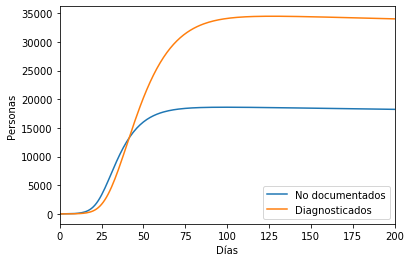

In [5]:
##=== Graficando primeros resultados ===###
plt.plot(t, Col_sol[:, 1], label="No documentados")
plt.plot(t, Col_sol[:, 2], label="Diagnosticados")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 200)
plt.legend()
plt.show()

Tomamos el número de casos reportados para __Colombia__ después del primer paciente positivo para COVID-19 en el territorio y lo ajustamos a nuestro modelo.

Los datos son tomados del [repositorio público para Covid-19 en GitHub](https://github.com/CSSEGISandData/COVID-19) cuyos datos son del CSSE
([Center for Systems Science and Engineering](https://systems.jhu.edu/))

In [6]:
##=== Importando series de Tiempo ===##

#Casos confirmados 
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

#Casos mortales 
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

#Pacientes recuperados
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [8]:
###=== Definiendo función para obtener series de tiempo por país ===###
def cases_plot(dfp, ctry): 
    ''' Función que grafica la serie de tiempo del país requerido en el dataframe dfp
    Entradas: dfp - dataframe con series de tiempo; country - string país
    Salida: array con serie de tiempo y gráfico de casos en el tiempo desde el primer caso en el país 
    '''
    
    df = dfp.groupby("Country/Region").sum()
    df.drop(['Lat', 'Long'], axis=1, inplace=True)
    
    Cases = df.loc[ctry][df.loc[ctry] > 0]
    
    num = len(Cases)
    X = np.arange(0, num)
    Y = df.loc[ctry][-num:]
    
    plt.figure(1)
    plt.plot(X, Y, label='{}'.format(ctry))
    
    plt.xlabel("días")
    plt.ylabel("casos")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    return Y

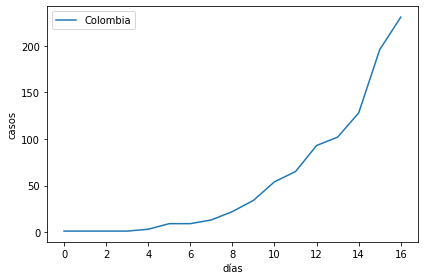

In [9]:
##=== Datos para Colombia ===##

Col_data = cases_plot(df_confirmed, "Colombia") #Casos confirmados
data_day = len(Col_data)  #Días desde que se confirmo el primer paciente

Si desea extraer los casos confirmados para algún país de interes, ingrese en la función cases_plot el nombre en ingles del país deseado, a continuación se muestra como ejemplo a Japón.

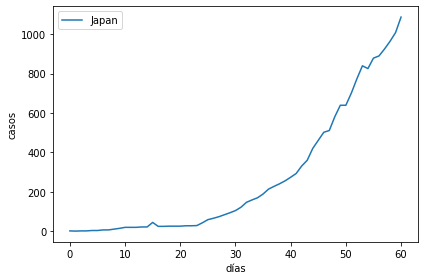

In [10]:
Japan_cases = cases_plot(df_confirmed, "Japan")

Ahora mostraremos los resultados de nuestro modelo y los casos confirmados para Colombia.

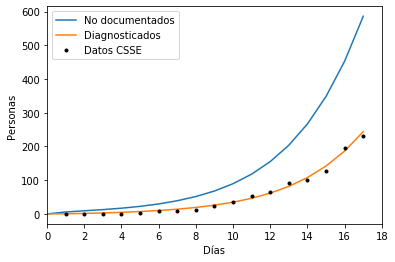

In [12]:
##=== Graficando primeros resultados y datos reportados ===###
plt.plot(t[0:data_day+1], Col_sol[0:data_day+1, 1], label="No documentados")
plt.plot(t[0:data_day+1], Col_sol[0:data_day+1, 2], label="Diagnosticados")
plt.plot(t[1:data_day+1], Col_data, 'k.', label="Datos CSSE")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, data_day+1)
plt.legend()
plt.show()

A partir del modelo mostrado, se propone visualizar __como sería la propagación si no hay intervención__ al modificar las tasas de contacto $\beta_i$

In [13]:
##=== Definiendo función de contacto directo modificada ===##
def betaf_mod(i, xc, x):
    b0 = [1.65*3.11*pow(10, -9), 1.6*0.62*pow(10, -9), 1.6*1.03*pow(10, -9)]
    c = [0, 0, 0] 
    #c = [1.01*pow(10, -4), 1.01*pow(10, -4), 1.01*pow(10, -4)]
    
    if x<xc:
        b = b0[i-1]
    else: 
        b = b0[i-1]*(1+c[i-1]*xc) / (1+c[i-1]*x)
    
    return b


def beta_mod(i, x): # forma reducida para c=[0,0,0]
    b0 = [1.65*3.11*pow(10, -9), 1.6*0.62*pow(10, -9), 1.6*1.03*pow(10, -9)]
    b = b0[i-1]
    return b

In [14]:
##=== solucionando ecuaciones para tasas modificadas ===##
Col_sol_mod = integrate.odeint(syst, sys0_n(5*10**7), t, args=(beta_mod, xi_2) )

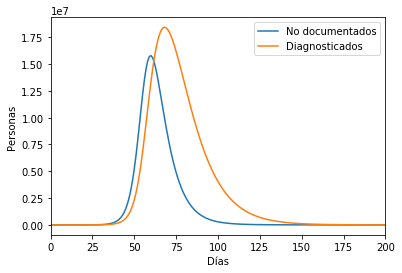

In [15]:
##=== Graficando nuevos resultados ===###
plt.plot(t, Col_sol_mod[:, 1], label="No documentados")
plt.plot(t, Col_sol_mod[:, 2], label="Diagnosticados")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.xlim(0, 200)
plt.legend()
plt.show()